In [1]:
from __future__ import print_function
import math
import torchvision.transforms as transforms
import torch
import torch.utils.data as data
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from tqdm import tqdm
from utils_BNN import neg_ELBO, Logger
from model_BNN import Small_conv_net
from model_SNN import Net
import matplotlib.pyplot as plt

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
       BatchNorm2d-2            [-1, 6, 28, 28]              12
          Softplus-3            [-1, 6, 28, 28]               0
         MaxPool2d-4            [-1, 6, 14, 14]               0
            Conv2d-5           [-1, 16, 10, 10]           2,416
       BatchNorm2d-6           [-1, 16, 10, 10]              32
          Softplus-7           [-1, 16, 10, 10]               0
         MaxPool2d-8             [-1, 16, 5, 5]               0
      FlattenLayer-9                  [-1, 400]               0
           Linear-10                  [-1, 120]          48,120
      BatchNorm1d-11                  [-1, 120]             240
         Softplus-12                  [-1, 120]               0
           Linear-13                   [-1, 10]           1,210
Total params: 52,486
Trainable params: 

In [2]:
use_cuda = torch.cuda.is_available()

learning_rate = 0.001
weight_decay = 0
batch_size = 16
num_epochs = 5

In [3]:
# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
    ])

In [ ]:
# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


# Bayesian net

In [ ]:
net= Small_conv_net(10, 3)

if use_cuda:
    net.cuda()

neg_elbo = neg_ELBO(loss=nn.CrossEntropyLoss())
optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [ ]:
logger = Logger(net)

In [ ]:
bayesian_train_acc = []
bayesian_val_acc = []
var_list = []
var_list = logger.get_logvariance(var_list)

mu_list = []
mu_list = logger.get_mean(mu_list)

var_grads = []
mean_grads = []


for epoch in range(1, num_epochs + 1):
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    m_train = math.ceil(len(train_data) / batch_size)
    m_test= math.ceil(len(test_data) / batch_size)

    net.train()

    total = 0
    correct = 0

    for batch_idx, (data, target) in zip(tqdm(range(m_train)),(train_loader)):
        # move tensors to GPU if CUDA is available
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        beta = 1/batch_size
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output, kl = net.probforward(data)

        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

        # calculate the batch loss
        loss = neg_elbo(output, target, kl, beta)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += (loss.item() * data.size(0))

    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for i, (test_input, test_target) in zip(tqdm(range(m_test)), test_loader):
        # for (test_data, test_target) in test_loader:
            test_input, test_target = test_input.cuda(), test_target.cuda()
            test_outputs, kl = net.probforward(test_input)
            _, test_predicted = torch.max(test_outputs.data, 1)
            test_total += test_target.size(0)
            test_correct += (test_predicted == test_target).sum().item()

    train_loss = train_loss / len(train_loader.dataset)

    bayesian_train_acc.append(correct / total)
    bayesian_val_acc.append(test_correct/ test_total)
    
    var_list = logger.get_logvariance(var_list)
    mu_list = logger.get_mean(mu_list)
    mean_grads = logger.get_mean_gradients(mean_grads)
    var_grads = logger.get_logvariance_gradients(var_grads)
    
        
    
    print('--------------------------------------------------------------')
    print('Epoch:', epoch)
    print('--------------------------------------------------------------')
    print('Trainig loss:', train_loss)
    print('--------------------------------------------------------------')
    print('Accuracy of the network on the train images: {} percent ({}/{})'.format (
            100 * correct / total, correct, total))
    print('--------------------------------------------------------------')
    try:
        print('Accuracy of the network on the test images: {} percent ({}/{})'.format (
                100 * test_correct/ test_total, test_correct,test_total))
        print('--------------------------------------------------------------')
    except:
        pass
            


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:04<00:00, 128.64it/s]


--------------------------------------------------------------
Epoch: 1
--------------------------------------------------------------
Trainig loss: 247266564804.44415
--------------------------------------------------------------
Accuracy of the network on the train images: 10.042 percent (5021/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 9.86 percent (986/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:04<00:00, 126.88it/s]


--------------------------------------------------------------
Epoch: 2
--------------------------------------------------------------
Trainig loss: 45438327332.53632
--------------------------------------------------------------
Accuracy of the network on the train images: 10.112 percent (5056/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 9.47 percent (947/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:04<00:00, 125.66it/s]


--------------------------------------------------------------
Epoch: 3
--------------------------------------------------------------
Trainig loss: 11726770417.99168
--------------------------------------------------------------
Accuracy of the network on the train images: 9.926 percent (4963/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 9.49 percent (949/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:05<00:00, 117.66it/s]


--------------------------------------------------------------
Epoch: 4
--------------------------------------------------------------
Trainig loss: 3177483773.1328
--------------------------------------------------------------
Accuracy of the network on the train images: 10.284 percent (5142/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 10.35 percent (1035/10000)
--------------------------------------------------------------


 72%|████████████████████████████████████████████████████████▌                     | 2264/3125 [00:42<00:16, 53.29it/s]

In [ ]:
figheight = 20
figwidth = 35
# fig, ax_array = plt.subplots(num_epochs, int(len(var_list)/num_epochs))
fig = plt.figure()
fig.set_figheight(figheight)
fig.set_figwidth(figwidth)
plt.subplots_adjust(hspace=2)
for i in range(1, len(var_list)+1):
    ax = fig.add_subplot(num_epochs+1, int(len(var_list)/(num_epochs+1)), i)
    plt.hist(var_list[i-1], bins=100, range=(min(var_list[i-1]), max(var_list[i-1])))
    plt.title('{}'.format(np.mean(var_list[i-1])))
    if i-1 % int(len(var_list)/num_epochs) == 0:
          plt.text(0.12, 0.92, 
                     bbox=dict(facecolor='white', boxstyle="round"),
                     horizontalalignment='center',
                     verticalalignment='center',
                     fontsize = 12,
                     transform = ax.transAxes,
                     s ='Variance: ')
plt.savefig('Variance0.01.pdf')

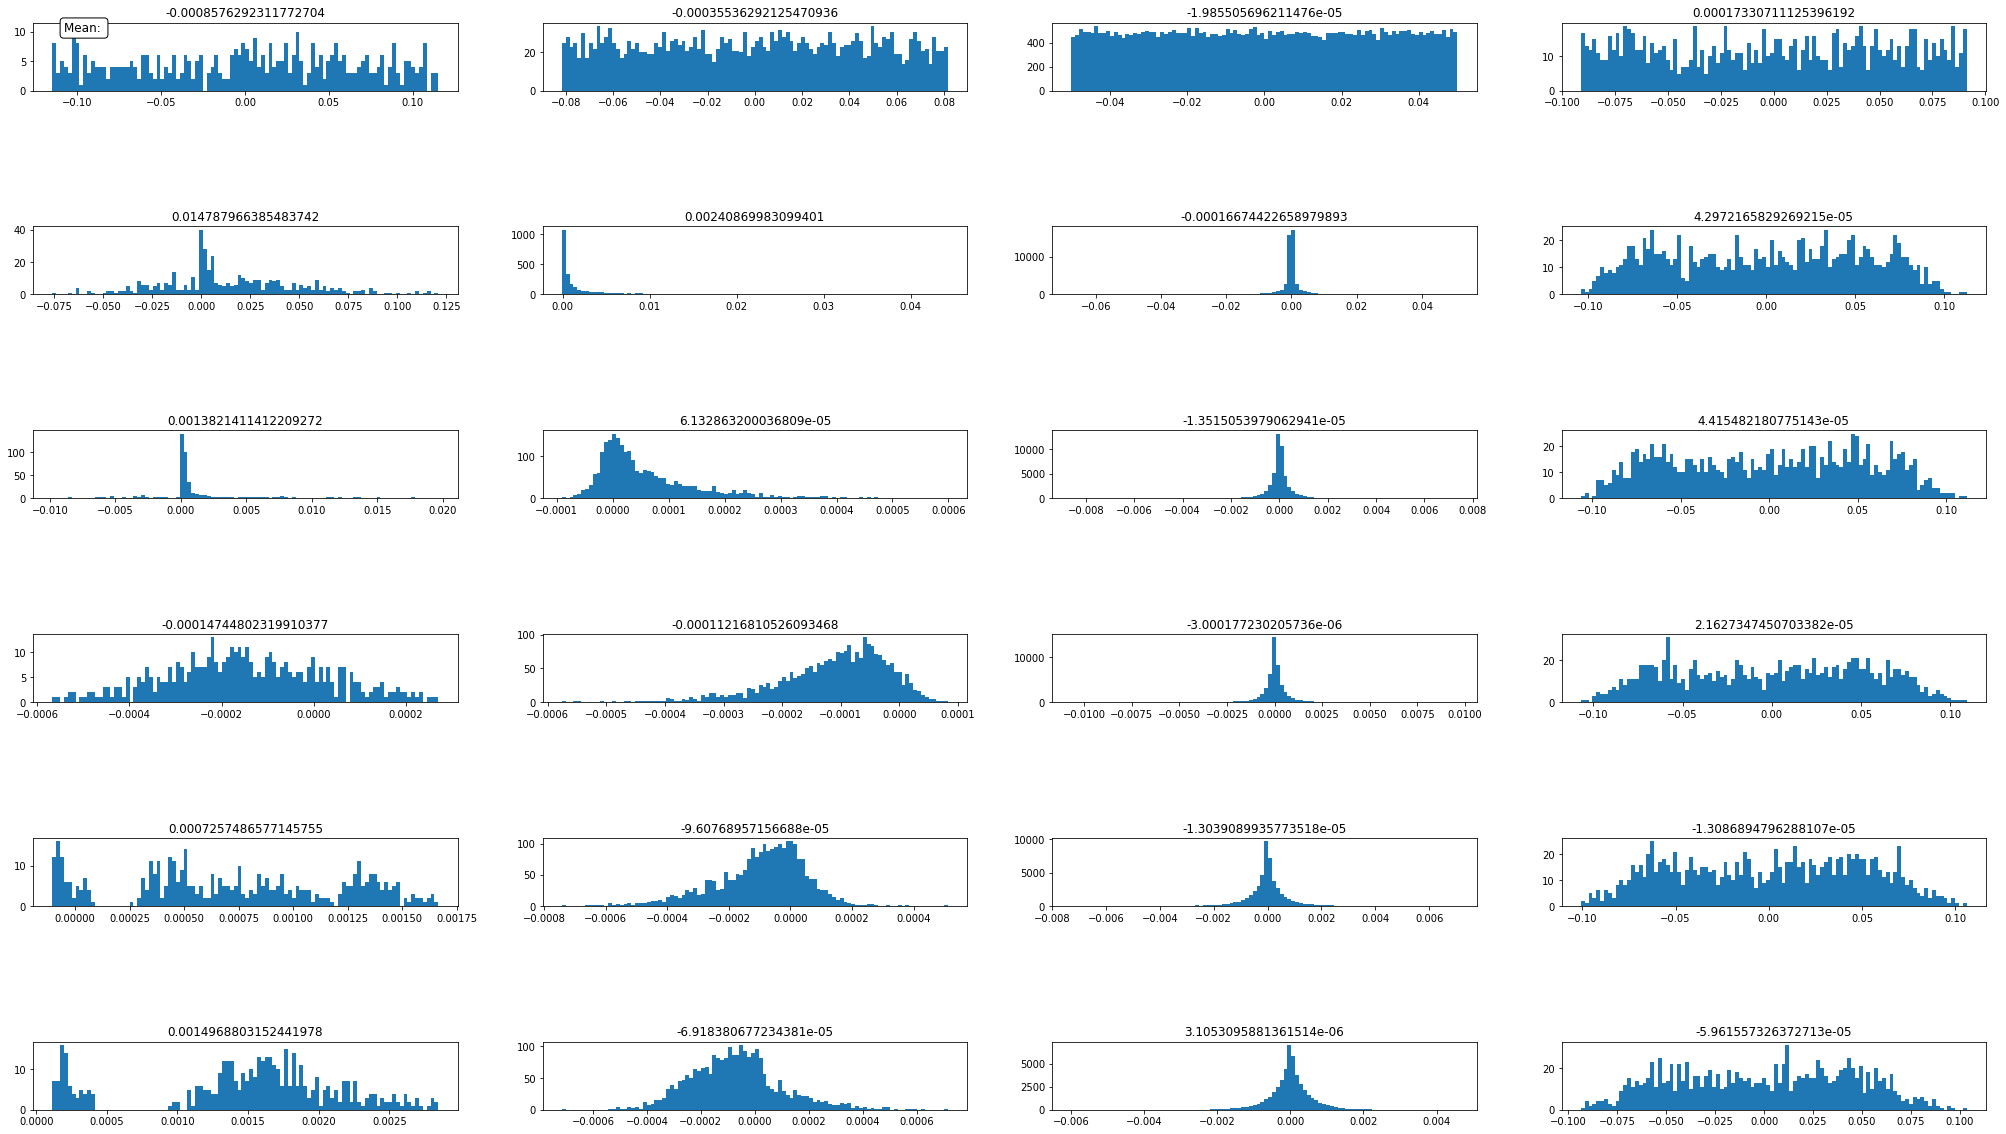

In [10]:
figheight = 20
figwidth = 35
# fig, ax_array = plt.subplots(num_epochs, int(len(mu_list)/num_epochs))
fig = plt.figure()
fig.set_figheight(figheight)
fig.set_figwidth(figwidth)
plt.subplots_adjust(hspace=2)
for i in range(1, len(mu_list)+1):
    ax = fig.add_subplot(num_epochs+1, int(len(mu_list)/(num_epochs+1)), i)
    plt.hist(mu_list[i-1], bins=100,)
    plt.title('{}'.format(np.mean(mu_list[i-1])))
    if i-1 % int(len(mu_list)/num_epochs) == 0:
          plt.text(0.12, 0.92, 
                     bbox=dict(facecolor='white', boxstyle="round"),
                     horizontalalignment='center',
                     verticalalignment='center',
                     fontsize = 12,
                     transform = ax.transAxes,
                     s ='Mean: ')
plt.savefig('Means.pdf')

In [10]:
figheight = 20
figwidth = 35

fig = plt.figure()
fig.set_figheight(figheight)
fig.set_figwidth(figwidth)

#adjust horizontal space between figures
plt.subplots_adjust(hspace=2)


for i in range(1, len(mean_grads)+1):
    ax = fig.add_subplot(num_epochs, int(len(mean_grads)/(num_epochs)), i)
    
    # Histogram over network params
    plt.hist(mean_grads[i-1], bins=100)
    
    # Set title of figures
    plt.title('{}'.format(np.mean(mean_grads[i-1])))
    
    if i-1 % int(len(mean_grads)/num_epochs) == 0:
          plt.text(0.12, 0.92, 
                     bbox=dict(facecolor='white', boxstyle="round"),
                     horizontalalignment='center',
                     verticalalignment='center',
                     fontsize = 12,
                     transform = ax.transAxes,
                     s ='Mean gradients: ')

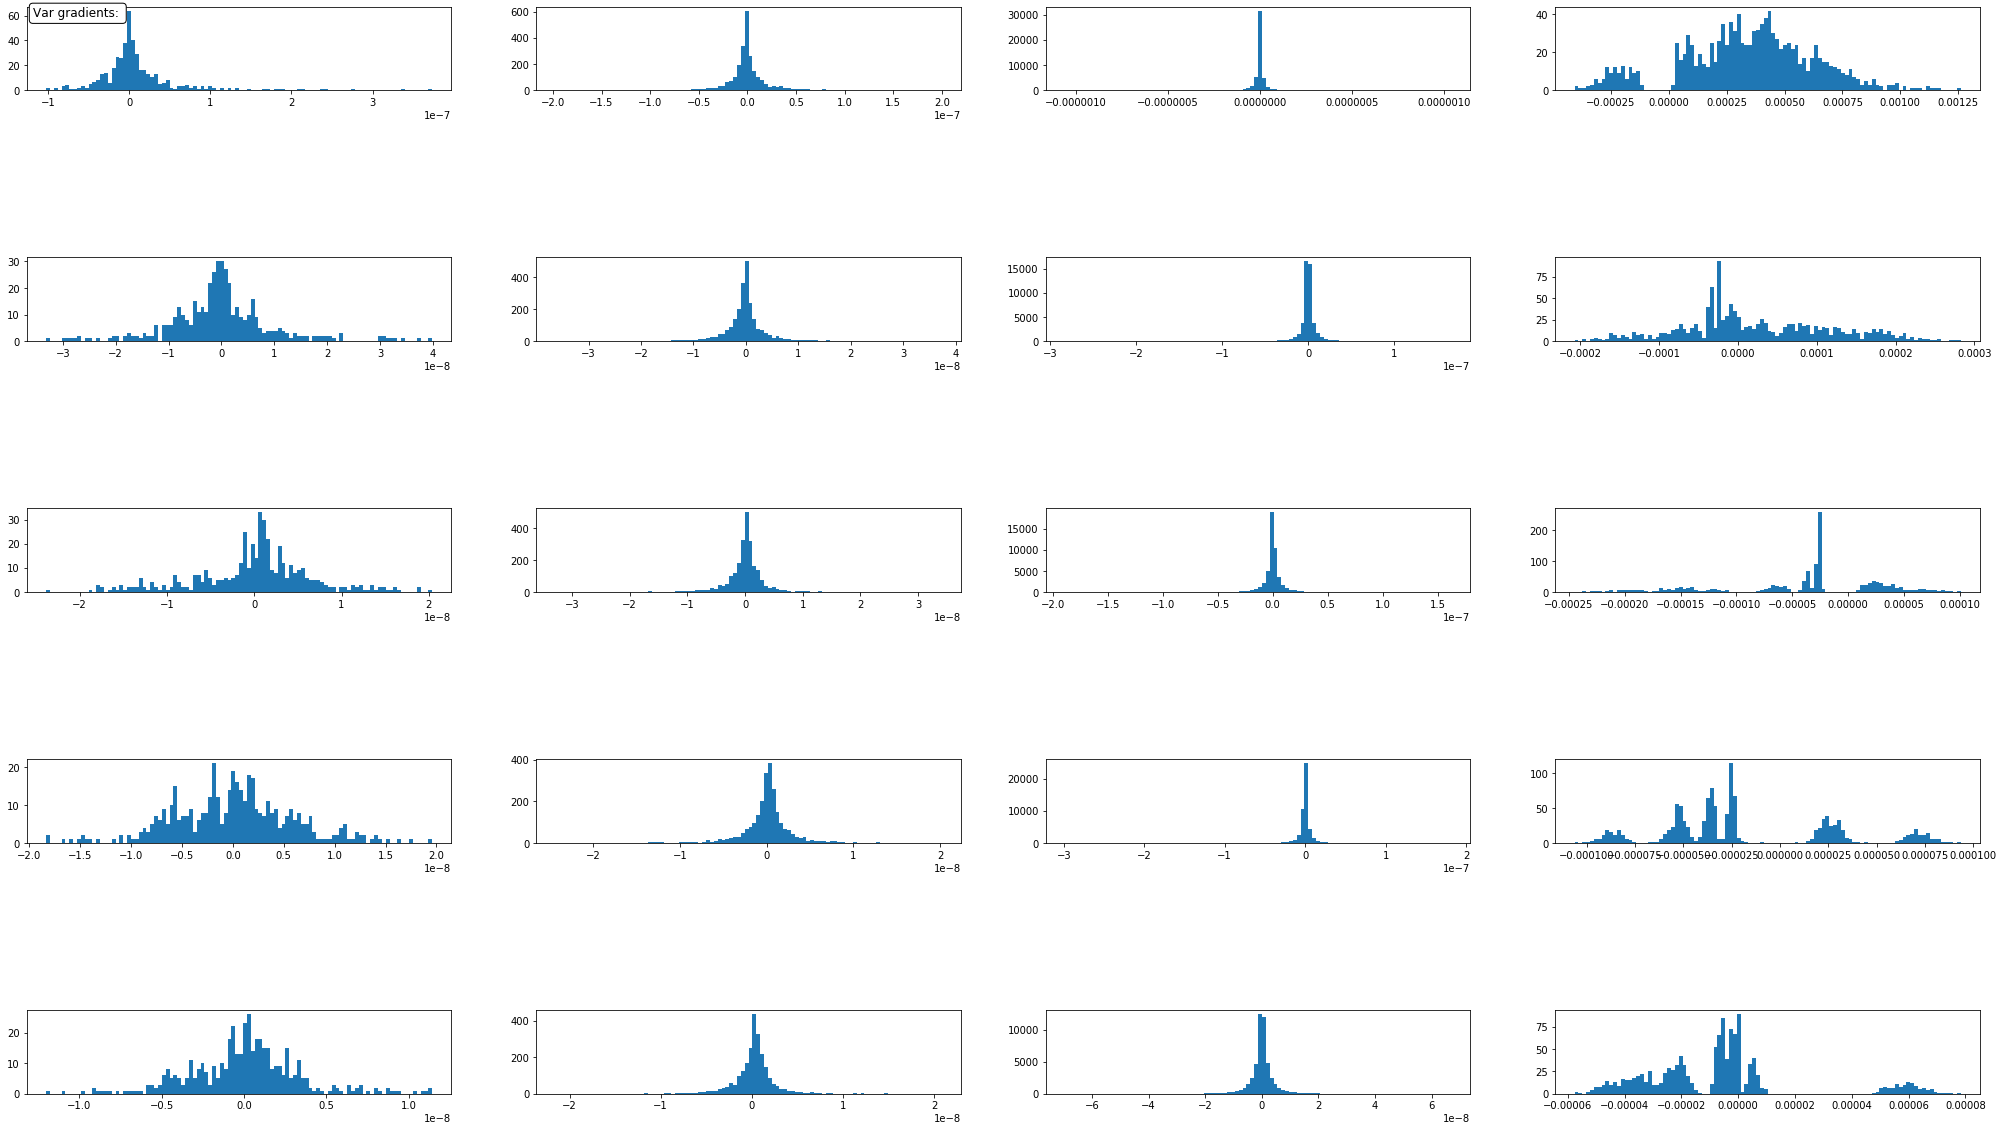

In [11]:
figheight = 20
figwidth = 35

fig = plt.figure()
fig.set_figheight(figheight)
fig.set_figwidth(figwidth)

#adjust horizontal space between figures
plt.subplots_adjust(hspace=2)


for i in range(1, len(var_grads)+1):
    ax = fig.add_subplot(num_epochs, int(len(var_grads)/(num_epochs)), i)
    
    # Histogram over network params
    plt.hist(var_grads[i-1], bins=100)
    
    # Set title of figures
#     plt.title('{}'.format(np.mean(var_grads[i-1])))
    
    if i-1 % int(len(var_grads)/num_epochs) == 0:
          plt.text(0.12, 0.92, 
                     bbox=dict(facecolor='white', boxstyle="round"),
                     horizontalalignment='center',
                     verticalalignment='center',
                     fontsize = 12,
                     transform = ax.transAxes,
                     s ='Var gradients: ')

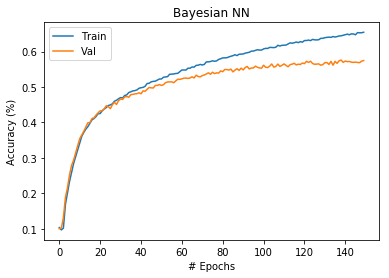

In [12]:
f = plt.figure(0)
plt.plot(range(len(bayesian_train_acc)),bayesian_train_acc)
plt.plot(range(len(bayesian_val_acc)),bayesian_val_acc)
plt.title('Bayesian NN')
plt.xlabel('# Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(('Train','Val'))
# f.savefig('bayes_acc.pdf')


# Frequentist Net

In [12]:
frequentist_net = Net()

if use_cuda:
    frequentist_net.cuda()

criterion=nn.CrossEntropyLoss()
optimizer = optim.Adam(frequentist_net.parameters(), lr=learning_rate)

In [13]:
frequentist_train_acc = []
frequentist_val_acc = []

for epoch in range(1, num_epochs + 1):
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    m_train = math.ceil(len(train_data) / batch_size)
    m_test= math.ceil(len(test_data) / batch_size)
    frequentist_net.train()

    total = 0
    correct = 0

    for batch_idx, (data, target) in zip(tqdm(range(m_train)),(train_loader)):
        # move tensors to GPU if CUDA is available
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = frequentist_net(data)

        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += (loss.item() * data.size(0))

    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for i, (test_input, test_target) in zip(tqdm(range(m_test)), test_loader):
        # for (test_data, test_target) in test_loader:
            test_input, test_target = test_input.cuda(), test_target.cuda()
            test_outputs= frequentist_net(test_input)
            _, test_predicted = torch.max(test_outputs.data, 1)
            test_total += test_target.size(0)
            test_correct += (test_predicted == test_target).sum().item()

    train_loss = train_loss / len(train_loader.dataset)

    frequentist_train_acc.append(correct / total)
    frequentist_val_acc.append(test_correct/ test_total)
        
    print('--------------------------------------------------------------')
    print('Epoch:', epoch)
    print('--------------------------------------------------------------')
    print('Trainig loss:', train_loss)
    print('--------------------------------------------------------------')
    print('Accuracy of the network on the train images: {} percent ({}/{})'.format (
            100 * correct / total, correct, total))
    print('--------------------------------------------------------------')

    print('Accuracy of the network on the test images: {} percent ({}/{})'.format (
            100 * test_correct/ test_total, test_correct,test_total))
    print('--------------------------------------------------------------')


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 221.81it/s]


--------------------------------------------------------------
Epoch: 1
--------------------------------------------------------------
Trainig loss: 1.5087161141204835
--------------------------------------------------------------
Accuracy of the network on the train images: 46.412 percent (23206/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 52.34 percent (5234/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 235.00it/s]


--------------------------------------------------------------
Epoch: 2
--------------------------------------------------------------
Trainig loss: 1.2616316634368896
--------------------------------------------------------------
Accuracy of the network on the train images: 55.616 percent (27808/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 56.37 percent (5637/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 235.47it/s]


--------------------------------------------------------------
Epoch: 3
--------------------------------------------------------------
Trainig loss: 1.1639540736579894
--------------------------------------------------------------
Accuracy of the network on the train images: 59.352 percent (29676/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 58.62 percent (5862/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 235.80it/s]


--------------------------------------------------------------
Epoch: 4
--------------------------------------------------------------
Trainig loss: 1.0977509757614137
--------------------------------------------------------------
Accuracy of the network on the train images: 61.648 percent (30824/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 59.54 percent (5954/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 240.53it/s]


--------------------------------------------------------------
Epoch: 5
--------------------------------------------------------------
Trainig loss: 1.0455710119628907
--------------------------------------------------------------
Accuracy of the network on the train images: 63.44 percent (31720/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 60.4 percent (6040/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 237.23it/s]


--------------------------------------------------------------
Epoch: 6
--------------------------------------------------------------
Trainig loss: 1.0013337186431885
--------------------------------------------------------------
Accuracy of the network on the train images: 64.982 percent (32491/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 61.01 percent (6101/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 234.51it/s]


--------------------------------------------------------------
Epoch: 7
--------------------------------------------------------------
Trainig loss: 0.9617972433948517
--------------------------------------------------------------
Accuracy of the network on the train images: 66.596 percent (33298/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 61.39 percent (6139/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 224.92it/s]


--------------------------------------------------------------
Epoch: 8
--------------------------------------------------------------
Trainig loss: 0.9257338355064392
--------------------------------------------------------------
Accuracy of the network on the train images: 67.862 percent (33931/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 61.69 percent (6169/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 240.93it/s]


--------------------------------------------------------------
Epoch: 9
--------------------------------------------------------------
Trainig loss: 0.8927027137184143
--------------------------------------------------------------
Accuracy of the network on the train images: 69.15 percent (34575/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 62.17 percent (6217/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 238.53it/s]


--------------------------------------------------------------
Epoch: 10
--------------------------------------------------------------
Trainig loss: 0.8616509060955048
--------------------------------------------------------------
Accuracy of the network on the train images: 70.28 percent (35140/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 62.28 percent (6228/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 231.94it/s]


--------------------------------------------------------------
Epoch: 11
--------------------------------------------------------------
Trainig loss: 0.8321639412689209
--------------------------------------------------------------
Accuracy of the network on the train images: 71.348 percent (35674/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 62.24 percent (6224/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 229.26it/s]


--------------------------------------------------------------
Epoch: 12
--------------------------------------------------------------
Trainig loss: 0.8039835689115524
--------------------------------------------------------------
Accuracy of the network on the train images: 72.426 percent (36213/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 62.3 percent (6230/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 238.84it/s]


--------------------------------------------------------------
Epoch: 13
--------------------------------------------------------------
Trainig loss: 0.7773325348949433
--------------------------------------------------------------
Accuracy of the network on the train images: 73.258 percent (36629/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 62.15 percent (6215/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 238.77it/s]


--------------------------------------------------------------
Epoch: 14
--------------------------------------------------------------
Trainig loss: 0.7515695217561722
--------------------------------------------------------------
Accuracy of the network on the train images: 74.264 percent (37132/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 62.02 percent (6202/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 236.07it/s]


--------------------------------------------------------------
Epoch: 15
--------------------------------------------------------------
Trainig loss: 0.7267774165439606
--------------------------------------------------------------
Accuracy of the network on the train images: 75.256 percent (37628/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 62.0 percent (6200/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 243.36it/s]


--------------------------------------------------------------
Epoch: 16
--------------------------------------------------------------
Trainig loss: 0.7027296014499664
--------------------------------------------------------------
Accuracy of the network on the train images: 76.176 percent (38088/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 61.77 percent (6177/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 240.81it/s]


--------------------------------------------------------------
Epoch: 17
--------------------------------------------------------------
Trainig loss: 0.6796528350067139
--------------------------------------------------------------
Accuracy of the network on the train images: 77.016 percent (38508/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 61.53 percent (6153/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 234.07it/s]


--------------------------------------------------------------
Epoch: 18
--------------------------------------------------------------
Trainig loss: 0.6575990484523773
--------------------------------------------------------------
Accuracy of the network on the train images: 77.92 percent (38960/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 61.08 percent (6108/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 234.67it/s]


--------------------------------------------------------------
Epoch: 19
--------------------------------------------------------------
Trainig loss: 0.6364533742046357
--------------------------------------------------------------
Accuracy of the network on the train images: 78.61 percent (39305/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 60.58 percent (6058/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 234.49it/s]


--------------------------------------------------------------
Epoch: 20
--------------------------------------------------------------
Trainig loss: 0.6162155209755897
--------------------------------------------------------------
Accuracy of the network on the train images: 79.368 percent (39684/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 60.35 percent (6035/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 237.38it/s]


--------------------------------------------------------------
Epoch: 21
--------------------------------------------------------------
Trainig loss: 0.5969029162740708
--------------------------------------------------------------
Accuracy of the network on the train images: 80.058 percent (40029/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 59.98 percent (5998/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 234.38it/s]


--------------------------------------------------------------
Epoch: 22
--------------------------------------------------------------
Trainig loss: 0.5784505459117889
--------------------------------------------------------------
Accuracy of the network on the train images: 80.74 percent (40370/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 59.54 percent (5954/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 231.94it/s]


--------------------------------------------------------------
Epoch: 23
--------------------------------------------------------------
Trainig loss: 0.5605719611811638
--------------------------------------------------------------
Accuracy of the network on the train images: 81.352 percent (40676/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 58.99 percent (5899/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 234.08it/s]


--------------------------------------------------------------
Epoch: 24
--------------------------------------------------------------
Trainig loss: 0.5434029938268662
--------------------------------------------------------------
Accuracy of the network on the train images: 81.91 percent (40955/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 58.78 percent (5878/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 241.64it/s]


--------------------------------------------------------------
Epoch: 25
--------------------------------------------------------------
Trainig loss: 0.5268688450336456
--------------------------------------------------------------
Accuracy of the network on the train images: 82.558 percent (41279/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 58.56 percent (5856/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 238.22it/s]


--------------------------------------------------------------
Epoch: 26
--------------------------------------------------------------
Trainig loss: 0.5106508036470413
--------------------------------------------------------------
Accuracy of the network on the train images: 83.276 percent (41638/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 58.32 percent (5832/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 237.09it/s]


--------------------------------------------------------------
Epoch: 27
--------------------------------------------------------------
Trainig loss: 0.4949160781240463
--------------------------------------------------------------
Accuracy of the network on the train images: 83.92 percent (41960/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 58.02 percent (5802/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 242.96it/s]


--------------------------------------------------------------
Epoch: 28
--------------------------------------------------------------
Trainig loss: 0.47970912331104276
--------------------------------------------------------------
Accuracy of the network on the train images: 84.5 percent (42250/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 57.91 percent (5791/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 238.89it/s]


--------------------------------------------------------------
Epoch: 29
--------------------------------------------------------------
Trainig loss: 0.4649038713932037
--------------------------------------------------------------
Accuracy of the network on the train images: 85.086 percent (42543/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 57.86 percent (5786/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 242.99it/s]


--------------------------------------------------------------
Epoch: 30
--------------------------------------------------------------
Trainig loss: 0.4505363691544533
--------------------------------------------------------------
Accuracy of the network on the train images: 85.756 percent (42878/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 57.61 percent (5761/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 240.71it/s]


--------------------------------------------------------------
Epoch: 31
--------------------------------------------------------------
Trainig loss: 0.43653943688988683
--------------------------------------------------------------
Accuracy of the network on the train images: 86.306 percent (43153/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 57.56 percent (5756/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 239.88it/s]


--------------------------------------------------------------
Epoch: 32
--------------------------------------------------------------
Trainig loss: 0.4230645467853546
--------------------------------------------------------------
Accuracy of the network on the train images: 86.83 percent (43415/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 57.43 percent (5743/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 236.77it/s]


--------------------------------------------------------------
Epoch: 33
--------------------------------------------------------------
Trainig loss: 0.4098296307873726
--------------------------------------------------------------
Accuracy of the network on the train images: 87.312 percent (43656/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 57.31 percent (5731/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 239.08it/s]


--------------------------------------------------------------
Epoch: 34
--------------------------------------------------------------
Trainig loss: 0.3971489736175537
--------------------------------------------------------------
Accuracy of the network on the train images: 87.692 percent (43846/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 57.31 percent (5731/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 239.46it/s]


--------------------------------------------------------------
Epoch: 35
--------------------------------------------------------------
Trainig loss: 0.38443379987835885
--------------------------------------------------------------
Accuracy of the network on the train images: 88.136 percent (44068/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 57.29 percent (5729/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 235.57it/s]


--------------------------------------------------------------
Epoch: 36
--------------------------------------------------------------
Trainig loss: 0.3727234226155281
--------------------------------------------------------------
Accuracy of the network on the train images: 88.6 percent (44300/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 56.91 percent (5691/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 227.70it/s]


--------------------------------------------------------------
Epoch: 37
--------------------------------------------------------------
Trainig loss: 0.3606402672767639
--------------------------------------------------------------
Accuracy of the network on the train images: 89.024 percent (44512/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 56.78 percent (5678/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 233.00it/s]


--------------------------------------------------------------
Epoch: 38
--------------------------------------------------------------
Trainig loss: 0.35019702093720434
--------------------------------------------------------------
Accuracy of the network on the train images: 89.334 percent (44667/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 56.44 percent (5644/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 230.52it/s]


--------------------------------------------------------------
Epoch: 39
--------------------------------------------------------------
Trainig loss: 0.3407819080066681
--------------------------------------------------------------
Accuracy of the network on the train images: 89.37 percent (44685/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 56.68 percent (5668/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 234.62it/s]


--------------------------------------------------------------
Epoch: 40
--------------------------------------------------------------
Trainig loss: 0.33561245451867583
--------------------------------------------------------------
Accuracy of the network on the train images: 89.278 percent (44639/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 56.37 percent (5637/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 240.85it/s]


--------------------------------------------------------------
Epoch: 41
--------------------------------------------------------------
Trainig loss: 0.3250207518720627
--------------------------------------------------------------
Accuracy of the network on the train images: 89.572 percent (44786/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 56.12 percent (5612/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 237.10it/s]


--------------------------------------------------------------
Epoch: 42
--------------------------------------------------------------
Trainig loss: 0.3167478872054815
--------------------------------------------------------------
Accuracy of the network on the train images: 89.85 percent (44925/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.95 percent (5595/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 231.56it/s]


--------------------------------------------------------------
Epoch: 43
--------------------------------------------------------------
Trainig loss: 0.3083062143671513
--------------------------------------------------------------
Accuracy of the network on the train images: 90.132 percent (45066/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 56.15 percent (5615/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 242.64it/s]


--------------------------------------------------------------
Epoch: 44
--------------------------------------------------------------
Trainig loss: 0.3026913505965471
--------------------------------------------------------------
Accuracy of the network on the train images: 90.13 percent (45065/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.81 percent (5581/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 235.82it/s]


--------------------------------------------------------------
Epoch: 45
--------------------------------------------------------------
Trainig loss: 0.2961608308684826
--------------------------------------------------------------
Accuracy of the network on the train images: 90.204 percent (45102/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.76 percent (5576/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 235.58it/s]


--------------------------------------------------------------
Epoch: 46
--------------------------------------------------------------
Trainig loss: 0.28618160652667285
--------------------------------------------------------------
Accuracy of the network on the train images: 90.512 percent (45256/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.7 percent (5570/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 235.87it/s]


--------------------------------------------------------------
Epoch: 47
--------------------------------------------------------------
Trainig loss: 0.2822409404337406
--------------------------------------------------------------
Accuracy of the network on the train images: 90.738 percent (45369/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.53 percent (5553/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 241.60it/s]


--------------------------------------------------------------
Epoch: 48
--------------------------------------------------------------
Trainig loss: 0.2717503101927042
--------------------------------------------------------------
Accuracy of the network on the train images: 90.98 percent (45490/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.48 percent (5548/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 230.43it/s]


--------------------------------------------------------------
Epoch: 49
--------------------------------------------------------------
Trainig loss: 0.2667122294804454
--------------------------------------------------------------
Accuracy of the network on the train images: 91.224 percent (45612/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.37 percent (5537/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 240.33it/s]


--------------------------------------------------------------
Epoch: 50
--------------------------------------------------------------
Trainig loss: 0.2637896868154406
--------------------------------------------------------------
Accuracy of the network on the train images: 91.158 percent (45579/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.77 percent (5577/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 240.09it/s]


--------------------------------------------------------------
Epoch: 51
--------------------------------------------------------------
Trainig loss: 0.2556023065909743
--------------------------------------------------------------
Accuracy of the network on the train images: 91.452 percent (45726/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.75 percent (5575/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 248.19it/s]


--------------------------------------------------------------
Epoch: 52
--------------------------------------------------------------
Trainig loss: 0.24780317880034447
--------------------------------------------------------------
Accuracy of the network on the train images: 91.698 percent (45849/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.86 percent (5586/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 237.89it/s]


--------------------------------------------------------------
Epoch: 53
--------------------------------------------------------------
Trainig loss: 0.24570366340816022
--------------------------------------------------------------
Accuracy of the network on the train images: 91.672 percent (45836/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.43 percent (5543/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 237.89it/s]


--------------------------------------------------------------
Epoch: 54
--------------------------------------------------------------
Trainig loss: 0.23955066188275814
--------------------------------------------------------------
Accuracy of the network on the train images: 91.926 percent (45963/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.77 percent (5577/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 237.15it/s]


--------------------------------------------------------------
Epoch: 55
--------------------------------------------------------------
Trainig loss: 0.23420851009607316
--------------------------------------------------------------
Accuracy of the network on the train images: 92.09 percent (46045/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.22 percent (5522/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 239.24it/s]


--------------------------------------------------------------
Epoch: 56
--------------------------------------------------------------
Trainig loss: 0.23089638569414617
--------------------------------------------------------------
Accuracy of the network on the train images: 92.06 percent (46030/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.73 percent (5573/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 235.48it/s]


--------------------------------------------------------------
Epoch: 57
--------------------------------------------------------------
Trainig loss: 0.22398201677381993
--------------------------------------------------------------
Accuracy of the network on the train images: 92.256 percent (46128/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.99 percent (5599/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 237.61it/s]


--------------------------------------------------------------
Epoch: 58
--------------------------------------------------------------
Trainig loss: 0.21814597694337368
--------------------------------------------------------------
Accuracy of the network on the train images: 92.576 percent (46288/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 56.08 percent (5608/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 238.78it/s]


--------------------------------------------------------------
Epoch: 59
--------------------------------------------------------------
Trainig loss: 0.21523440629929305
--------------------------------------------------------------
Accuracy of the network on the train images: 92.682 percent (46341/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.68 percent (5568/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 237.76it/s]


--------------------------------------------------------------
Epoch: 60
--------------------------------------------------------------
Trainig loss: 0.20854584975659848
--------------------------------------------------------------
Accuracy of the network on the train images: 92.858 percent (46429/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.62 percent (5562/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 239.23it/s]


--------------------------------------------------------------
Epoch: 61
--------------------------------------------------------------
Trainig loss: 0.20752463586628436
--------------------------------------------------------------
Accuracy of the network on the train images: 92.752 percent (46376/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.56 percent (5556/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 242.72it/s]


--------------------------------------------------------------
Epoch: 62
--------------------------------------------------------------
Trainig loss: 0.2039038735845685
--------------------------------------------------------------
Accuracy of the network on the train images: 92.934 percent (46467/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.72 percent (5572/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 213.96it/s]


--------------------------------------------------------------
Epoch: 63
--------------------------------------------------------------
Trainig loss: 0.19665600509881973
--------------------------------------------------------------
Accuracy of the network on the train images: 93.214 percent (46607/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.56 percent (5556/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 226.65it/s]


--------------------------------------------------------------
Epoch: 64
--------------------------------------------------------------
Trainig loss: 0.1935566525286436
--------------------------------------------------------------
Accuracy of the network on the train images: 93.338 percent (46669/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.74 percent (5574/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 236.99it/s]


--------------------------------------------------------------
Epoch: 65
--------------------------------------------------------------
Trainig loss: 0.18901491441965104
--------------------------------------------------------------
Accuracy of the network on the train images: 93.442 percent (46721/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.8 percent (5580/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 232.52it/s]


--------------------------------------------------------------
Epoch: 66
--------------------------------------------------------------
Trainig loss: 0.19014007891625165
--------------------------------------------------------------
Accuracy of the network on the train images: 93.294 percent (46647/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.47 percent (5547/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 245.81it/s]


--------------------------------------------------------------
Epoch: 67
--------------------------------------------------------------
Trainig loss: 0.18361637078911067
--------------------------------------------------------------
Accuracy of the network on the train images: 93.654 percent (46827/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.49 percent (5549/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 233.31it/s]


--------------------------------------------------------------
Epoch: 68
--------------------------------------------------------------
Trainig loss: 0.18088804828166963
--------------------------------------------------------------
Accuracy of the network on the train images: 93.628 percent (46814/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.59 percent (5559/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 234.84it/s]


--------------------------------------------------------------
Epoch: 69
--------------------------------------------------------------
Trainig loss: 0.17749934213683008
--------------------------------------------------------------
Accuracy of the network on the train images: 93.734 percent (46867/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.69 percent (5569/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 231.18it/s]


--------------------------------------------------------------
Epoch: 70
--------------------------------------------------------------
Trainig loss: 0.17298495583981274
--------------------------------------------------------------
Accuracy of the network on the train images: 93.952 percent (46976/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.86 percent (5586/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 235.69it/s]


--------------------------------------------------------------
Epoch: 71
--------------------------------------------------------------
Trainig loss: 0.170038932287693
--------------------------------------------------------------
Accuracy of the network on the train images: 93.896 percent (46948/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.42 percent (5542/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 216.30it/s]


--------------------------------------------------------------
Epoch: 72
--------------------------------------------------------------
Trainig loss: 0.16781624018847943
--------------------------------------------------------------
Accuracy of the network on the train images: 94.022 percent (47011/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.67 percent (5567/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 238.58it/s]


--------------------------------------------------------------
Epoch: 73
--------------------------------------------------------------
Trainig loss: 0.16292379127144813
--------------------------------------------------------------
Accuracy of the network on the train images: 94.158 percent (47079/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.54 percent (5554/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 235.64it/s]


--------------------------------------------------------------
Epoch: 74
--------------------------------------------------------------
Trainig loss: 0.15971046094581484
--------------------------------------------------------------
Accuracy of the network on the train images: 94.292 percent (47146/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.44 percent (5544/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 234.43it/s]


--------------------------------------------------------------
Epoch: 75
--------------------------------------------------------------
Trainig loss: 0.15626968073785305
--------------------------------------------------------------
Accuracy of the network on the train images: 94.43 percent (47215/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.69 percent (5569/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 239.07it/s]


--------------------------------------------------------------
Epoch: 76
--------------------------------------------------------------
Trainig loss: 0.15795968294113874
--------------------------------------------------------------
Accuracy of the network on the train images: 94.398 percent (47199/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.35 percent (5535/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 237.98it/s]


--------------------------------------------------------------
Epoch: 77
--------------------------------------------------------------
Trainig loss: 0.14977947658061982
--------------------------------------------------------------
Accuracy of the network on the train images: 94.63 percent (47315/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.03 percent (5503/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 245.47it/s]


--------------------------------------------------------------
Epoch: 78
--------------------------------------------------------------
Trainig loss: 0.14975905200749637
--------------------------------------------------------------
Accuracy of the network on the train images: 94.616 percent (47308/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.04 percent (5504/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 239.51it/s]


--------------------------------------------------------------
Epoch: 79
--------------------------------------------------------------
Trainig loss: 0.14869029695495964
--------------------------------------------------------------
Accuracy of the network on the train images: 94.796 percent (47398/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.21 percent (5521/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 241.12it/s]


--------------------------------------------------------------
Epoch: 80
--------------------------------------------------------------
Trainig loss: 0.14776781408786774
--------------------------------------------------------------
Accuracy of the network on the train images: 94.734 percent (47367/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 54.78 percent (5478/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 237.08it/s]


--------------------------------------------------------------
Epoch: 81
--------------------------------------------------------------
Trainig loss: 0.1444180309472978
--------------------------------------------------------------
Accuracy of the network on the train images: 94.872 percent (47436/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 54.98 percent (5498/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 237.20it/s]


--------------------------------------------------------------
Epoch: 82
--------------------------------------------------------------
Trainig loss: 0.14231686744362115
--------------------------------------------------------------
Accuracy of the network on the train images: 95.01 percent (47505/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.22 percent (5522/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 241.53it/s]


--------------------------------------------------------------
Epoch: 83
--------------------------------------------------------------
Trainig loss: 0.13462273783117532
--------------------------------------------------------------
Accuracy of the network on the train images: 95.25 percent (47625/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 54.73 percent (5473/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 229.90it/s]


--------------------------------------------------------------
Epoch: 84
--------------------------------------------------------------
Trainig loss: 0.13839841389507054
--------------------------------------------------------------
Accuracy of the network on the train images: 95.072 percent (47536/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.15 percent (5515/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 240.06it/s]


--------------------------------------------------------------
Epoch: 85
--------------------------------------------------------------
Trainig loss: 0.13192982293248176
--------------------------------------------------------------
Accuracy of the network on the train images: 95.356 percent (47678/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.47 percent (5547/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 235.62it/s]


--------------------------------------------------------------
Epoch: 86
--------------------------------------------------------------
Trainig loss: 0.1314983678945899
--------------------------------------------------------------
Accuracy of the network on the train images: 95.294 percent (47647/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 54.88 percent (5488/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 229.90it/s]


--------------------------------------------------------------
Epoch: 87
--------------------------------------------------------------
Trainig loss: 0.12712254319086672
--------------------------------------------------------------
Accuracy of the network on the train images: 95.412 percent (47706/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.34 percent (5534/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 241.88it/s]


--------------------------------------------------------------
Epoch: 88
--------------------------------------------------------------
Trainig loss: 0.12950980455257
--------------------------------------------------------------
Accuracy of the network on the train images: 95.41 percent (47705/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.05 percent (5505/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 240.40it/s]


--------------------------------------------------------------
Epoch: 89
--------------------------------------------------------------
Trainig loss: 0.12720650646954776
--------------------------------------------------------------
Accuracy of the network on the train images: 95.53 percent (47765/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 54.74 percent (5474/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 237.16it/s]


--------------------------------------------------------------
Epoch: 90
--------------------------------------------------------------
Trainig loss: 0.12311392440214754
--------------------------------------------------------------
Accuracy of the network on the train images: 95.606 percent (47803/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.29 percent (5529/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 234.21it/s]


--------------------------------------------------------------
Epoch: 91
--------------------------------------------------------------
Trainig loss: 0.12691256375044585
--------------------------------------------------------------
Accuracy of the network on the train images: 95.488 percent (47744/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.36 percent (5536/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 239.02it/s]


--------------------------------------------------------------
Epoch: 92
--------------------------------------------------------------
Trainig loss: 0.12294593576788902
--------------------------------------------------------------
Accuracy of the network on the train images: 95.496 percent (47748/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.22 percent (5522/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 239.98it/s]


--------------------------------------------------------------
Epoch: 93
--------------------------------------------------------------
Trainig loss: 0.11804766542136669
--------------------------------------------------------------
Accuracy of the network on the train images: 95.796 percent (47898/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.14 percent (5514/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 230.41it/s]


--------------------------------------------------------------
Epoch: 94
--------------------------------------------------------------
Trainig loss: 0.11974721754770726
--------------------------------------------------------------
Accuracy of the network on the train images: 95.706 percent (47853/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 54.86 percent (5486/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 242.03it/s]


--------------------------------------------------------------
Epoch: 95
--------------------------------------------------------------
Trainig loss: 0.11605295726843179
--------------------------------------------------------------
Accuracy of the network on the train images: 95.914 percent (47957/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.23 percent (5523/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 234.42it/s]


--------------------------------------------------------------
Epoch: 96
--------------------------------------------------------------
Trainig loss: 0.11572773093461991
--------------------------------------------------------------
Accuracy of the network on the train images: 95.868 percent (47934/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.42 percent (5542/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 246.15it/s]


--------------------------------------------------------------
Epoch: 97
--------------------------------------------------------------
Trainig loss: 0.11223969067201019
--------------------------------------------------------------
Accuracy of the network on the train images: 96.058 percent (48029/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.18 percent (5518/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 232.81it/s]


--------------------------------------------------------------
Epoch: 98
--------------------------------------------------------------
Trainig loss: 0.11123014026626944
--------------------------------------------------------------
Accuracy of the network on the train images: 96.0 percent (48000/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.16 percent (5516/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 240.25it/s]


--------------------------------------------------------------
Epoch: 99
--------------------------------------------------------------
Trainig loss: 0.11181785537347197
--------------------------------------------------------------
Accuracy of the network on the train images: 95.922 percent (47961/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.34 percent (5534/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 229.49it/s]


--------------------------------------------------------------
Epoch: 100
--------------------------------------------------------------
Trainig loss: 0.1105626452819258
--------------------------------------------------------------
Accuracy of the network on the train images: 96.046 percent (48023/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 54.98 percent (5498/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 240.44it/s]


--------------------------------------------------------------
Epoch: 101
--------------------------------------------------------------
Trainig loss: 0.10672226353842765
--------------------------------------------------------------
Accuracy of the network on the train images: 96.16 percent (48080/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.33 percent (5533/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 235.52it/s]


--------------------------------------------------------------
Epoch: 102
--------------------------------------------------------------
Trainig loss: 0.10613199319228529
--------------------------------------------------------------
Accuracy of the network on the train images: 96.15 percent (48075/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.23 percent (5523/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 241.40it/s]


--------------------------------------------------------------
Epoch: 103
--------------------------------------------------------------
Trainig loss: 0.10829607720904053
--------------------------------------------------------------
Accuracy of the network on the train images: 96.074 percent (48037/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 54.91 percent (5491/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 228.67it/s]


--------------------------------------------------------------
Epoch: 104
--------------------------------------------------------------
Trainig loss: 0.10475839735545218
--------------------------------------------------------------
Accuracy of the network on the train images: 96.264 percent (48132/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.13 percent (5513/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 234.33it/s]


--------------------------------------------------------------
Epoch: 105
--------------------------------------------------------------
Trainig loss: 0.10563390653461217
--------------------------------------------------------------
Accuracy of the network on the train images: 96.24 percent (48120/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.11 percent (5511/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 239.44it/s]


--------------------------------------------------------------
Epoch: 106
--------------------------------------------------------------
Trainig loss: 0.10289281846344471
--------------------------------------------------------------
Accuracy of the network on the train images: 96.35 percent (48175/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 54.56 percent (5456/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 240.57it/s]


--------------------------------------------------------------
Epoch: 107
--------------------------------------------------------------
Trainig loss: 0.10076899655852467
--------------------------------------------------------------
Accuracy of the network on the train images: 96.404 percent (48202/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.38 percent (5538/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 239.01it/s]


--------------------------------------------------------------
Epoch: 108
--------------------------------------------------------------
Trainig loss: 0.10044419555336237
--------------------------------------------------------------
Accuracy of the network on the train images: 96.368 percent (48184/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 54.72 percent (5472/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 228.31it/s]


--------------------------------------------------------------
Epoch: 109
--------------------------------------------------------------
Trainig loss: 0.09920229302309454
--------------------------------------------------------------
Accuracy of the network on the train images: 96.446 percent (48223/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 54.33 percent (5433/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 243.78it/s]


--------------------------------------------------------------
Epoch: 110
--------------------------------------------------------------
Trainig loss: 0.09938084197983146
--------------------------------------------------------------
Accuracy of the network on the train images: 96.488 percent (48244/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.05 percent (5505/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 235.43it/s]


--------------------------------------------------------------
Epoch: 111
--------------------------------------------------------------
Trainig loss: 0.09157887184787541
--------------------------------------------------------------
Accuracy of the network on the train images: 96.628 percent (48314/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.27 percent (5527/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 243.35it/s]


--------------------------------------------------------------
Epoch: 112
--------------------------------------------------------------
Trainig loss: 0.0952552248582989
--------------------------------------------------------------
Accuracy of the network on the train images: 96.612 percent (48306/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 54.89 percent (5489/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 240.76it/s]


--------------------------------------------------------------
Epoch: 113
--------------------------------------------------------------
Trainig loss: 0.09457285552628339
--------------------------------------------------------------
Accuracy of the network on the train images: 96.586 percent (48293/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 54.07 percent (5407/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 237.96it/s]


--------------------------------------------------------------
Epoch: 114
--------------------------------------------------------------
Trainig loss: 0.09940852091424167
--------------------------------------------------------------
Accuracy of the network on the train images: 96.434 percent (48217/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 54.56 percent (5456/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 242.36it/s]


--------------------------------------------------------------
Epoch: 115
--------------------------------------------------------------
Trainig loss: 0.08771826834321023
--------------------------------------------------------------
Accuracy of the network on the train images: 96.822 percent (48411/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 54.84 percent (5484/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 246.32it/s]


--------------------------------------------------------------
Epoch: 116
--------------------------------------------------------------
Trainig loss: 0.09333535177007317
--------------------------------------------------------------
Accuracy of the network on the train images: 96.734 percent (48367/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.02 percent (5502/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 239.90it/s]


--------------------------------------------------------------
Epoch: 117
--------------------------------------------------------------
Trainig loss: 0.09262990162655711
--------------------------------------------------------------
Accuracy of the network on the train images: 96.644 percent (48322/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 54.67 percent (5467/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 248.38it/s]


--------------------------------------------------------------
Epoch: 118
--------------------------------------------------------------
Trainig loss: 0.09053317441437393
--------------------------------------------------------------
Accuracy of the network on the train images: 96.7 percent (48350/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 54.38 percent (5438/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 236.32it/s]


--------------------------------------------------------------
Epoch: 119
--------------------------------------------------------------
Trainig loss: 0.09096439164670184
--------------------------------------------------------------
Accuracy of the network on the train images: 96.808 percent (48404/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.27 percent (5527/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 236.67it/s]


--------------------------------------------------------------
Epoch: 120
--------------------------------------------------------------
Trainig loss: 0.0855353128187731
--------------------------------------------------------------
Accuracy of the network on the train images: 96.936 percent (48468/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.01 percent (5501/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 245.64it/s]


--------------------------------------------------------------
Epoch: 121
--------------------------------------------------------------
Trainig loss: 0.08297573835745453
--------------------------------------------------------------
Accuracy of the network on the train images: 97.04 percent (48520/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.23 percent (5523/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 238.36it/s]


--------------------------------------------------------------
Epoch: 122
--------------------------------------------------------------
Trainig loss: 0.08734858946647495
--------------------------------------------------------------
Accuracy of the network on the train images: 96.862 percent (48431/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 54.74 percent (5474/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 242.48it/s]


--------------------------------------------------------------
Epoch: 123
--------------------------------------------------------------
Trainig loss: 0.08739584723014385
--------------------------------------------------------------
Accuracy of the network on the train images: 96.87 percent (48435/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.05 percent (5505/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 232.97it/s]


--------------------------------------------------------------
Epoch: 124
--------------------------------------------------------------
Trainig loss: 0.08350931836571544
--------------------------------------------------------------
Accuracy of the network on the train images: 97.034 percent (48517/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 54.98 percent (5498/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 242.58it/s]


--------------------------------------------------------------
Epoch: 125
--------------------------------------------------------------
Trainig loss: 0.09024861521042883
--------------------------------------------------------------
Accuracy of the network on the train images: 96.644 percent (48322/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 54.47 percent (5447/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 247.13it/s]


--------------------------------------------------------------
Epoch: 126
--------------------------------------------------------------
Trainig loss: 0.07905915339358151
--------------------------------------------------------------
Accuracy of the network on the train images: 97.198 percent (48599/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.11 percent (5511/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 243.56it/s]


--------------------------------------------------------------
Epoch: 127
--------------------------------------------------------------
Trainig loss: 0.08338917686201631
--------------------------------------------------------------
Accuracy of the network on the train images: 97.004 percent (48502/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.15 percent (5515/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 236.14it/s]


--------------------------------------------------------------
Epoch: 128
--------------------------------------------------------------
Trainig loss: 0.0793862676140666
--------------------------------------------------------------
Accuracy of the network on the train images: 97.178 percent (48589/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.01 percent (5501/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 237.97it/s]


--------------------------------------------------------------
Epoch: 129
--------------------------------------------------------------
Trainig loss: 0.08149682981021703
--------------------------------------------------------------
Accuracy of the network on the train images: 97.03 percent (48515/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 54.86 percent (5486/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 240.48it/s]


--------------------------------------------------------------
Epoch: 130
--------------------------------------------------------------
Trainig loss: 0.08234547964263707
--------------------------------------------------------------
Accuracy of the network on the train images: 96.99 percent (48495/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.73 percent (5573/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 233.74it/s]


--------------------------------------------------------------
Epoch: 131
--------------------------------------------------------------
Trainig loss: 0.07956621769949794
--------------------------------------------------------------
Accuracy of the network on the train images: 97.212 percent (48606/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 54.66 percent (5466/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 243.43it/s]


--------------------------------------------------------------
Epoch: 132
--------------------------------------------------------------
Trainig loss: 0.07894102802714333
--------------------------------------------------------------
Accuracy of the network on the train images: 97.17 percent (48585/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 54.91 percent (5491/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 243.20it/s]


--------------------------------------------------------------
Epoch: 133
--------------------------------------------------------------
Trainig loss: 0.07568859196912497
--------------------------------------------------------------
Accuracy of the network on the train images: 97.272 percent (48636/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 54.99 percent (5499/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 242.85it/s]


--------------------------------------------------------------
Epoch: 134
--------------------------------------------------------------
Trainig loss: 0.07885266757257282
--------------------------------------------------------------
Accuracy of the network on the train images: 97.162 percent (48581/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.15 percent (5515/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 240.15it/s]


--------------------------------------------------------------
Epoch: 135
--------------------------------------------------------------
Trainig loss: 0.07467500797253102
--------------------------------------------------------------
Accuracy of the network on the train images: 97.376 percent (48688/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.22 percent (5522/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 238.01it/s]


--------------------------------------------------------------
Epoch: 136
--------------------------------------------------------------
Trainig loss: 0.07727043562298641
--------------------------------------------------------------
Accuracy of the network on the train images: 97.288 percent (48644/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 54.88 percent (5488/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 235.88it/s]


--------------------------------------------------------------
Epoch: 137
--------------------------------------------------------------
Trainig loss: 0.07272869415994733
--------------------------------------------------------------
Accuracy of the network on the train images: 97.354 percent (48677/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.33 percent (5533/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 234.89it/s]


--------------------------------------------------------------
Epoch: 138
--------------------------------------------------------------
Trainig loss: 0.07536289030849934
--------------------------------------------------------------
Accuracy of the network on the train images: 97.3 percent (48650/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.09 percent (5509/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 235.97it/s]


--------------------------------------------------------------
Epoch: 139
--------------------------------------------------------------
Trainig loss: 0.07419634571747855
--------------------------------------------------------------
Accuracy of the network on the train images: 97.302 percent (48651/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.11 percent (5511/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 235.17it/s]


--------------------------------------------------------------
Epoch: 140
--------------------------------------------------------------
Trainig loss: 0.07807394746970385
--------------------------------------------------------------
Accuracy of the network on the train images: 97.17 percent (48585/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.48 percent (5548/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 234.19it/s]


--------------------------------------------------------------
Epoch: 141
--------------------------------------------------------------
Trainig loss: 0.07389367847338318
--------------------------------------------------------------
Accuracy of the network on the train images: 97.302 percent (48651/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 54.69 percent (5469/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 236.92it/s]


--------------------------------------------------------------
Epoch: 142
--------------------------------------------------------------
Trainig loss: 0.07127689327441156
--------------------------------------------------------------
Accuracy of the network on the train images: 97.388 percent (48694/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 54.97 percent (5497/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 236.84it/s]


--------------------------------------------------------------
Epoch: 143
--------------------------------------------------------------
Trainig loss: 0.07136553668789565
--------------------------------------------------------------
Accuracy of the network on the train images: 97.446 percent (48723/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 54.76 percent (5476/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 235.61it/s]


--------------------------------------------------------------
Epoch: 144
--------------------------------------------------------------
Trainig loss: 0.07474749945100397
--------------------------------------------------------------
Accuracy of the network on the train images: 97.358 percent (48679/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 54.86 percent (5486/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 236.89it/s]


--------------------------------------------------------------
Epoch: 145
--------------------------------------------------------------
Trainig loss: 0.07232127323046326
--------------------------------------------------------------
Accuracy of the network on the train images: 97.464 percent (48732/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 54.91 percent (5491/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 238.44it/s]


--------------------------------------------------------------
Epoch: 146
--------------------------------------------------------------
Trainig loss: 0.07011598097326234
--------------------------------------------------------------
Accuracy of the network on the train images: 97.566 percent (48783/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.1 percent (5510/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 243.47it/s]


--------------------------------------------------------------
Epoch: 147
--------------------------------------------------------------
Trainig loss: 0.06831700198430568
--------------------------------------------------------------
Accuracy of the network on the train images: 97.544 percent (48772/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 54.96 percent (5496/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 235.94it/s]


--------------------------------------------------------------
Epoch: 148
--------------------------------------------------------------
Trainig loss: 0.07137411958359181
--------------------------------------------------------------
Accuracy of the network on the train images: 97.5 percent (48750/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 54.58 percent (5458/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 229.65it/s]


--------------------------------------------------------------
Epoch: 149
--------------------------------------------------------------
Trainig loss: 0.06864302266791462
--------------------------------------------------------------
Accuracy of the network on the train images: 97.568 percent (48784/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.19 percent (5519/10000)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:02<00:00, 239.13it/s]


--------------------------------------------------------------
Epoch: 150
--------------------------------------------------------------
Trainig loss: 0.06862320175323636
--------------------------------------------------------------
Accuracy of the network on the train images: 97.626 percent (48813/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.13 percent (5513/10000)
--------------------------------------------------------------


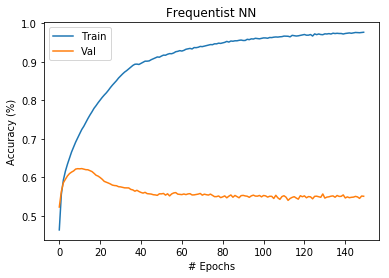

In [14]:
f = plt.figure(0)
plt.plot(range(len(frequentist_train_acc)),frequentist_train_acc)
plt.plot(range(len(frequentist_val_acc)),frequentist_val_acc)
plt.title('Frequentist NN')
plt.xlabel('# Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(('Train','Val'))
f.savefig('freq_acc.pdf')